# Import libraries

In [1]:
from requests_html import HTMLSession
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline

/Users/federico/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/federico/anaconda3/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [2]:
from stop_words import get_stop_words
stop_words = get_stop_words('italian')
stop_words.append('titolo')

In [3]:
pd.set_option('display.max_colwidth', 150)

In [4]:
session = HTMLSession()

# Scrape 'La Repubblica'

In [5]:
url_rep = 'https://ricerca.repubblica.it/ricerca/repubblica?ref=HRHS&query=elezioni&filter_type=articolo&page=2'
r_rep = session.get(url_rep)
r_rep.status_code

200

In [6]:
def scrape_rep(url):
    
    '''Scrapes "La Repubblica", search page and returns Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('''[title="Leggi l'articolo"]''')
    article_list = []
    for article in article_info:
        article_list.append(article.text)
        
    article_df = pd.DataFrame(article_list)
    return article_df

In [7]:
def search_rep(searchterm, pages):
    '''Scrapes Titles from "La Repubblica"'''
    
    results_dfs = []
    for page in range(1,pages+1):
        url = 'https://ricerca.repubblica.it/ricerca/repubblica?ref=HRHS&query=' + searchterm + '&filter_type=articolo&page=' + str(page)
        df = scrape_rep(url)
        results_dfs.append(df)
    results_dfs = pd.concat(results_dfs)
    return results_dfs

In [8]:
test_rep = search_rep('elezioni', 4)

# Scrape 'La Stampa'

In [9]:
url_st = 'https://www.lastampa.it/ricerca?search=elezioni%20AND%20sections:italia/cronache*%20&pagina=3'
r_st = session.get(url_st)
r_st.status_code

200

In [10]:
def scrape_stampa(url):
    
    '''Scrapes "La Stampa", search page and returns Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('.titolo')
    article_list = []
    for article in article_info:
        article_list.append(article.text)
        
    article_df = pd.DataFrame(article_list)
    return article_df

In [11]:
def search_stampa(searchterm, pages):
    '''Scrapes Titles from "La Stampa"'''
    
    results_dfs = []
    for page in range(1,pages+1):
        url = 'https://www.lastampa.it/ricerca?search=' + searchterm + '%20AND%20sections:italia/cronache*%20&pagina=' + str(page)
        df = scrape_stampa(url)
        results_dfs.append(df)
    results_dfs = pd.concat(results_dfs)
    return results_dfs

In [12]:
test_st = search_stampa('voto', 3)

# Scrape 'Il Mattino'

In [13]:
url_mat = 'https://www.ilmattino.it/home_page.php?p=search&q=europa&start=80'
r_mat = session.get(url_mat)
r_mat.status_code

200

In [14]:
def scrape_ilmattino(url):
    
    '''Scrapes "Il Mattino", search page and returns URLs and Title'''
    r = session.get(url)
    parsed_html = r.html
    article_info = parsed_html.find('h3')
    article_list = []
    for article in article_info:
        article_list.append(article.text)

        
    article_df = pd.DataFrame(article_list)
    return article_df

In [15]:
def search_matt(searchterm, page):
    '''Searches "Il Mattino". 
       Returns a df of titles'''
    
    results_dfs = []
    
    for page in range(0, page):
       
        url = 'https://www.ilmattino.it/home_page.php?p=search&q=' + searchterm + '&start=' + str(page*40)
        df = scrape_ilmattino(url)
        results_dfs.append(df)
    result_df = pd.concat(results_dfs)
    return result_df

In [16]:
test_mat = search_matt('europa', 2)

# Topic word 1: 'Elezioni'

# a) La Repubblica

In [17]:
elections_rep = search_rep('elezioni', 100)

In [18]:
elections_rep.head()

,0
0,no titolo
1,no titolo
2,"Elezioni, se decidono gli indecisi"
3,no titolo
4,no titolo


In [19]:
elections_rep.tail()

,0
8,
9,"Sabir, dal 16 al 19 maggio a Lecce il festival delle culture del Mediterraneo"
10,
11,Lite continua
12,DOVE CI PUÒ PORTARE QUELLA FOTO


In [20]:
elections_rep.describe()

,0
count,1073
unique,903
top,
freq,76


In [21]:
elections_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073 entries, 0 to 12
Data columns (total 1 columns):
0    1073 non-null object
dtypes: object(1)
memory usage: 16.8+ KB


In [22]:
elections_rep = elections_rep.rename(columns = {0:"Titles"})

In [23]:
%matplotlib inline

In [24]:
def word_count(text_string):
    '''Calculate the length of a string, removing em-dashes.'''
    return len(text_string.split())
    edited_text_string = text_string.replace('—', '')
    return len(edited_text_string.split())

In [25]:
elections_rep['word_numb'] = elections_rep['Titles'].apply(word_count)

In [26]:
elections_rep['word_numb'].describe()

count    1073.000000
mean        7.537745
std         4.243599
min         0.000000
25%         4.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: word_numb, dtype: float64

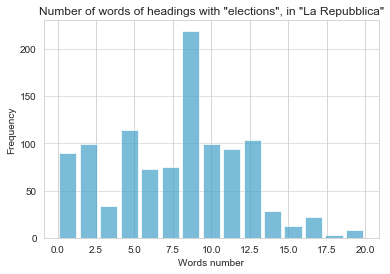

In [27]:
n, bins, patches = plt.hist(x=elections_rep['word_numb'], bins='auto', color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "La Repubblica"''')
maxfreq = n.max()

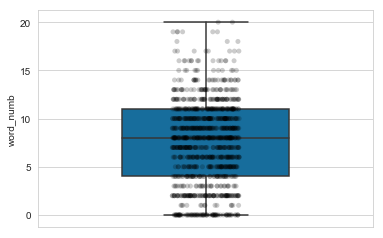

In [28]:
sns.boxplot(y = 'word_numb', 
                 data = elections_rep, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_rep, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

Word count, using Vectorizer

In [240]:
vectorizer_el_rep = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [241]:
vectorizer_el_rep.fit(elections_rep['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [242]:
len(vectorizer_el_rep.get_feature_names())

35

In [243]:
vectorizer_el_rep.get_feature_names()[0:10]

['campagna',
 'candidati',
 'comune',
 'corsa',
 'così',
 'destra',
 'dopo',
 'elettorale',
 'elezioni',
 'elezioni europee']

In [244]:
frequency_el_rep = vectorizer_el_rep.transform(elections_rep['Titles'])

In [245]:
frequency_el_rep

<1073x35 sparse matrix of type '<class 'numpy.int64'>'
	with 861 stored elements in Compressed Sparse Row format>

In [231]:
wordfreq_el_rep = pd.DataFrame(frequency_el_rep.toarray(),
                            columns = vectorizer_el_rep.get_feature_names(),
                            index = elections_rep.index)

In [232]:
wordfreq_el_rep.head()

,candidati,elezioni,europa,europee,italia,lega,pd,rai,salvini,sinistra,voto,zingaretti
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [233]:
wordfreq_el_rep.tail()

,candidati,elezioni,europa,europee,italia,lega,pd,rai,salvini,sinistra,voto,zingaretti
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0


In [234]:
wordfreq_el_rep.sum().sort_values(ascending=False)[:20]

elezioni      102
europee        63
pd             58
europa         57
salvini        47
voto           39
lega           36
italia         32
zingaretti     27
sinistra       26
candidati      23
rai            22
dtype: int64

In [235]:
df_freq_el_rep = wordfreq_el_rep.sum().sort_values(ascending=False)[:20]

In [236]:
pd.DataFrame(df_freq_el_rep)

,0
elezioni,102
europee,63
pd,58
europa,57
salvini,47
voto,39
lega,36
italia,32
zingaretti,27
sinistra,26


In [237]:
df_freq_el_rep.to_csv('freq_el_rep.csv')

In [238]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=45, fontsize = 18) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

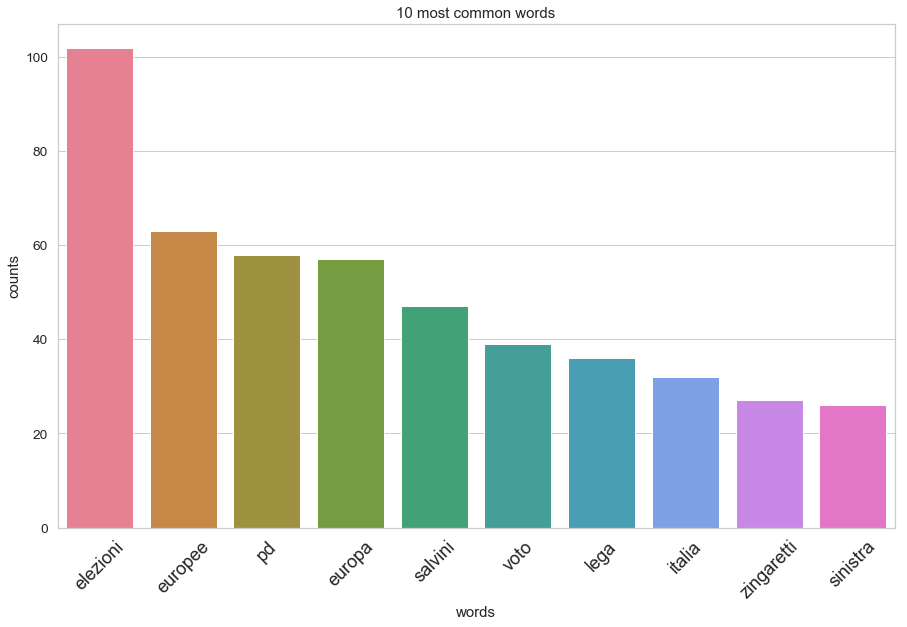

In [239]:
plot_10_most_common_words(frequency_el_rep, vectorizer_el_rep)

Latent Dirichlet Allocation

In [41]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_rep = LatentDirichletAllocation(n_components = model)
        lda_model_el_rep.fit(frequency_el_rep)
        loglik = lda_model_el_rep.score(frequency_el_rep)
        perpl = lda_model_el_rep.perplexity(frequency_el_rep)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-2931.446289,29.868641
1,2,-3014.330279,32.879549
2,3,-3069.802186,35.062383
3,4,-3158.958045,38.878370
4,5,-3170.229184,39.389468
5,6,-3164.485143,39.128166
6,7,-3174.687777,39.593496
7,8,-3206.037807,41.058245
8,9,-3214.770805,41.475837
9,10,-3213.734490,41.426061


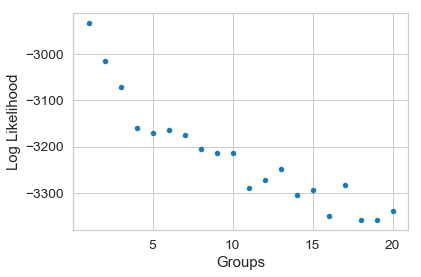

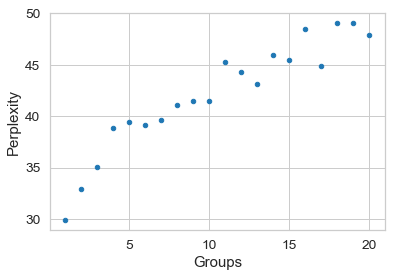

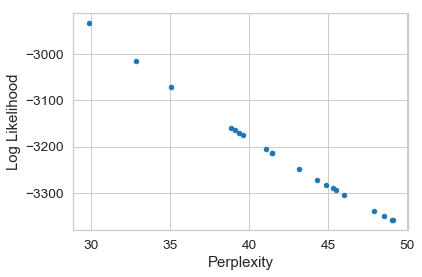

In [42]:
best_groups(20)

In [43]:
lda_model_el_rep = LatentDirichletAllocation(n_components = 6)

In [44]:
lda_model_el_rep.fit(frequency_el_rep)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [45]:
print("Log Likelihood: ", lda_model_el_rep.score(frequency_el_rep))

print("Perplexity: ", lda_model_el_rep.perplexity(frequency_el_rep))

Log Likelihood:  -3179.340505149029
Perplexity:  39.80753457373386


In [46]:
print(lda_model_el_rep.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 6, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [47]:
pyLDAvis.enable_notebook()
panel_el_rep = pyLDAvis.sklearn.prepare(lda_model_el_rep, frequency_el_rep, vectorizer_el_rep, mds='tsne')
panel_el_rep

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3       -7.960482  -20.271765       1        1  19.835126
2       -1.375653 -196.857620       2        1  19.435609
4     -117.090919  118.710716       3        1  18.102714
0     -173.867859  -81.108681       4        1  15.328233
5       90.499077  126.464714       5        1  14.225427
1      162.016220  -68.574280       6        1  13.072892, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
8     Default  97.000000          elezioni  97.000000  30.0000  30.0000
10    Default  55.000000            europa  55.000000  29.0000  29.0000
33    Default  41.000000              voto  41.000000  28.0000  28.0000
11    Default  64.000000           europee  64.000000  27.0000  27.0000
23    Default  54.000000                pd  54.000000  26.0000  26.0000
29    Default  27.000000          sinistra  27.000000  25.0000  25.0000
26    Default  44.000000           salvini  44.000000  24.0000  24.0000
17    Default  33.000000              lega  33.000000  23.0000  23.0000
16    Default  31.000000            italia  31.000000  22.0000  22.0000
25    Default  23.000000               rai  23.000000  21.0000  21.0000
34    Default  25.000000        zingaretti  25.000000  20.0000  20.0000
22    Default  19.000000               ora  19.000000  19.0000  19.0000
1     Default  22.000000         candidati  22.000000  18.0000  18.0000
2     Default  16.000000            comune  16.000000  17.0000  17.0000
4     Default  16.000000              così  16.000000  16.0000  16.0000
15    Default  18.000000           governo  18.000000  15.0000  15.0000
20    Default  18.000000              maio  18.000000  14.0000  14.0000
9     Default  19.000000  elezioni europee  19.000000  13.0000  13.0000
30    Default  16.000000              solo  16.000000  12.0000  12.0000
13    Default  16.000000             forza  16.000000  11.0000  11.0000
0     Default  14.000000          campagna  14.000000  10.0000  10.0000
6     Default  12.000000              dopo  12.000000   9.0000   9.0000
5     Default  15.000000            destra  15.000000   8.0000   8.0000
21    Default  12.000000           milioni  12.000000   7.0000   7.0000
31    Default  15.000000                ue  15.000000   6.0000   6.0000
12    Default  14.000000                fa  14.000000   5.0000   5.0000
28    Default  13.000000           sindaco  13.000000   4.0000   4.0000
7     Default  11.000000        elettorale  11.000000   3.0000   3.0000
14    Default  12.000000      forza italia  12.000000   2.0000   2.0000
19    Default  12.000000            maggio  12.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
24     Topic6   0.174687          politica  10.891059  -2.0981  -6.4705
7      Topic6   0.174600        elettorale  11.395813  -2.1439  -6.4710
3      Topic6   0.174870             corsa  11.685952  -2.1675  -6.4695
19     Topic6   0.174874            maggio  12.297521  -2.2185  -6.4695
21     Topic6   0.174567           milioni  12.305676  -2.2209  -6.4712
14     Topic6   0.174436      forza italia  12.297438  -2.2210  -6.4720
28     Topic6   0.174603           sindaco  13.241387  -2.2940  -6.4710
27     Topic6   0.174378             sfida  13.979344  -2.3495  -6.4723
0      Topic6   0.174373          campagna  14.239076  -2.3679  -6.4723
32     Topic6   0.174901                va  14.288825  -2.3684  -6.4693
12     Topic6   0.174600                fa  14.498622  -2.3847  -6.4710
18     Topic6   0.174376               m5s  14.962826  -2.4175  -6.4723
5      Topic6   0.174572            destra  15.129199  -2.4274  -6.4712
31     Topic6   0.174376                ue  15.400442  -2.4463  -6.4723
13     Topic6   0.174577             forza  16.073127  -2.4879  -6.4712
30     Topic6   0.174751             

In [48]:
def column_swap(column):
    column = column.sort_values(ascending = False)
    return column.index

In [49]:
def topic_words_df(lda_model, vectorizer):
    '''
    Generate dataframe of words associated with a topic model.
    '''
    
    word_topic_scores = lda_model.components_.T
    vocabulary        = vectorizer.get_feature_names()
    
    
    topic_words_df = pd.DataFrame(word_topic_scores,
                                  index = vocabulary)
    
    topic_words_df = topic_words_df.apply(column_swap).reset_index(drop = True).rename_axis('rank')
    
    topic_words_df.index = topic_words_df.index + 1
    
    return topic_words_df

In [50]:
topic_words_df(lda_model_el_rep, vectorizer_el_rep).head(10)

,0,1,2,3,4,5
rank,,,,,,
1,elezioni,voto,europa,pd,salvini,europee
2,governo,rai,elezioni,lega,italia,sinistra
3,solo,comune,candidati,zingaretti,maio,ora
4,campagna,così,europee,ue,forza,milioni
5,elettorale,dopo,elezioni europee,fa,destra,pd
6,dopo,va,va,politica,sindaco,corsa
7,milioni,candidati,sfida,salvini,forza italia,m5s
8,m5s,maggio,corsa,m5s,maggio,va
9,fa,corsa,italia,sfida,m5s,campagna


In [51]:
topics_el_rep = lda_model_el_rep.transform(frequency_el_rep)

In [52]:
pd.DataFrame(topics_el_rep).head(10)

,0,1,2,3,4,5
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
6,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
7,0.582944,0.083333,0.083723,0.083333,0.083333,0.083333
8,0.033703,0.033333,0.832656,0.033333,0.033333,0.033641
9,0.042315,0.041667,0.791000,0.041667,0.041685,0.041667


In [53]:
spacy.cli.download("it")

✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')
✔ Linking successful
/Users/federico/anaconda3/lib/python3.7/site-packages/it_core_news_sm -->
/Users/federico/anaconda3/lib/python3.7/site-packages/spacy/data/it
You can now load the model via spacy.load('it')


In [54]:
nlp = spacy.load('it')

In [55]:
def extract_adjectives(text):
    adjectives = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'ADJ':
            adjectives.append(token.text)
    adjectives = ', '.join(adjectives)
    return adjectives

In [56]:
elections_rep['Adjectives'] = elections_rep['Titles'].apply(extract_adjectives)

In [57]:
elections_rep['Adjectives']

0                          
1                          
2                          
3                          
4                          
5                          
6              Gran, finale
7                    scambi
8                   europee
9                          
0                      urne
1                   europeo
2                          
3                   europeo
4                          
5                   Europee
6                   europeo
7                   europeo
8                          
9                          
0                          
1                          
2                   europeo
3                          
4              indifferenti
5                          
6                          
7                          
8                   Europee
9                     vuota
              ...          
5                          
6                          
7                sovranista
8                   europee
9                   

In [58]:
vectorizer_el_rep2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [59]:
vectorizer_el_rep2.fit(elections_rep['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [60]:
wf_el_rep = vectorizer_el_rep2.transform(elections_rep['Adjectives'])

In [61]:
df_el_rep = pd.DataFrame(wf_el_rep.todense(),
                        columns = vectorizer_el_rep2.get_feature_names())

In [62]:
df_el_rep.sum().sort_values(ascending=False)

europee        30
elettorale     11
ex              9
europeo         7
sovranista      7
urne            7
migranti        6
nuovo           6
ultimo          6
anti            6
nuovi           5
destra          5
regionali       5
primo           5
comunali        4
populista       4
antimafia       4
elettorali      4
voto            4
comune          3
sindaca         3
spagnole        3
leghista        3
grillini        3
grandi          3
secondo         3
italiani        3
ultima          3
prime           3
italiana        3
               ..
pericolosa      1
proibito        1
procurarsi      1
precari         1
pre             1
povero          1
potenziali      1
possibile       1
pole            1
pieno           1
piemontese      1
piccoli         1
personali       1
pericolose      1
perfetta        1
neofascista     1
pentiti         1
penale          1
patria          1
palco           1
orfana          1
opposta         1
operaio         1
olimpiche       1
olandese  

# b) La Stampa

In [63]:
elections_st = search_stampa('elezioni', 100)

In [64]:
elections_st.head()

,0
0,"Elezioni, ecco gli sconti sul viaggio in treno, aereo, bus e autostrade"
1,"Martina: il Pd va rifondato alla radice, deve rappresentare i lavoratori"
2,"Tra i leghisti nel mito di Alberto da Giussano “Crediamo al primo cittadino, meno ai pm”"
3,"Chi è Giambattista Fratus, il sindaco di Legnano vicino a Salvini"
4,A Roma una fronda contro Pignatone nella guerra di successione in Procura


In [65]:
elections_st.tail()

,0
5,"Festa M5S, palco vietato a Pizzarotti Un piano del Pd per “degrillizzarlo”"
6,"Sospeso De Magistris, elezioni più vicine"
7,L’ex pm non si piega alla giustizia: “Dobbiamo fare resistenza”
8,“La mia nuova vita in Svezia tra gli incubi di quella notte e il rumore della neve sui tetti”
9,De Magistris verso la sospensione: “Ma mi ricandiderò”


In [66]:
elections_st.describe()

,0
count,1000
unique,998
top,A Roma una fronda contro Pignatone nella guerra di successione in Procura
freq,2


In [67]:
elections_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 9
Data columns (total 1 columns):
0    1000 non-null object
dtypes: object(1)
memory usage: 15.6+ KB


In [68]:
elections_st = elections_st.rename(columns = {0:"Titles"})

In [69]:
elections_st['word_numb'] = elections_st['Titles'].apply(word_count)

In [70]:
elections_st['word_numb'].describe()

count    1000.000000
mean       11.124000
std         2.899143
min         0.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

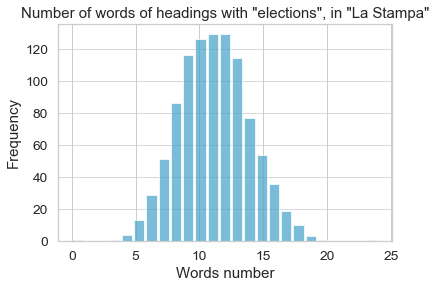

In [71]:
n, bins, patches = plt.hist(x=elections_st['word_numb'], bins=25, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "La Stampa"''')
maxfreq = n.max()

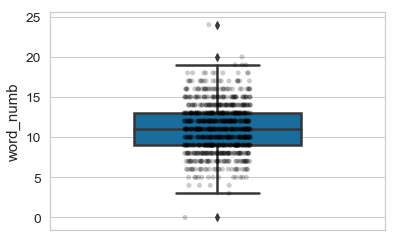

In [72]:
sns.boxplot(y = 'word_numb', 
                 data = elections_st, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_st, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [183]:
vectorizer_el_st = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [186]:
vectorizer_el_st.fit(elections_st['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [187]:
vectorizer_el_st.get_feature_names()[0:10]

['alema',
 'alfano',
 'anni',
 'anti',
 'arrestato',
 'basta',
 'berlusconi',
 'candidato',
 'capitale',
 'centrodestra']

In [188]:
frequency_el_st = vectorizer_el_st.transform(elections_st['Titles'])

In [189]:
frequency_el_st

<1000x80 sparse matrix of type '<class 'numpy.int64'>'
	with 1623 stored elements in Compressed Sparse Row format>

In [190]:
wordfreq_el_st = pd.DataFrame(frequency_el_st.toarray(),
                            columns = vectorizer_el_st.get_feature_names(),
                            index = elections_st.index)

In [191]:
wordfreq_el_st.head()

,alema,alfano,anni,anti,arrestato,basta,berlusconi,candidato,capitale,centrodestra,...,sud,sì,ue,urne,va,verso,via,voti,voto,vuole
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
wordfreq_el_st.tail()

,alema,alfano,anni,anti,arrestato,basta,berlusconi,candidato,capitale,centrodestra,...,sud,sì,ue,urne,va,verso,via,voti,voto,vuole
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [193]:
wordfreq_el_st.sum().sort_values(ascending=False)[:20]

pd            83
renzi         75
italia        63
berlusconi    60
voto          53
salvini       49
roma          44
governo       43
elezioni      35
m5s           35
ora           35
ex            30
così          28
sindaco       27
lega          27
maio          26
forza         25
partito       25
gentiloni     24
anni          22
dtype: int64

In [194]:
df_freq_el_st = wordfreq_el_st.sum().sort_values(ascending=False)[:20]

In [195]:
pd.DataFrame(df_freq_el_st)

,0
pd,83
renzi,75
italia,63
berlusconi,60
voto,53
salvini,49
roma,44
governo,43
elezioni,35
m5s,35


In [196]:
df_freq_el_st.to_csv('freq_el_st.csv')

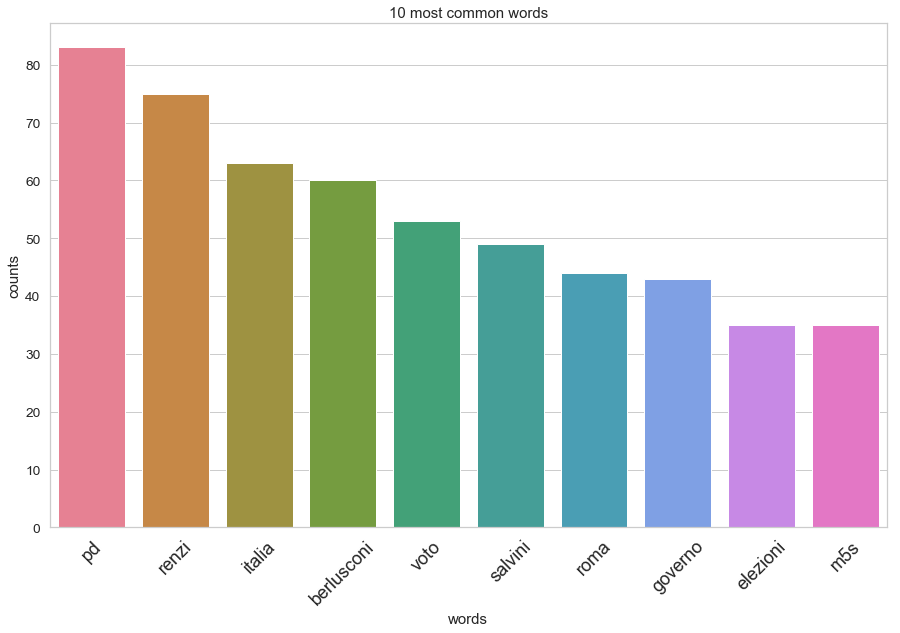

In [197]:
plot_10_most_common_words(frequency_el_st, vectorizer_el_st)

Latent Dirichlet Allocation

In [83]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_st = LatentDirichletAllocation(n_components = model)
        lda_model_el_st.fit(frequency_el_st)
        loglik = lda_model_el_st.score(frequency_el_st)
        perpl = lda_model_el_st.perplexity(frequency_el_st)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-6932.287417,71.425139
1,2,-7110.736429,79.720940
2,3,-7272.696464,88.081398
3,4,-7330.354041,91.264766
4,5,-7381.375375,94.177555
5,6,-7510.551164,101.974586
6,7,-7501.300748,101.395383
7,8,-7571.669725,105.885488
8,9,-7535.414192,103.547803
9,10,-7560.098411,105.133715


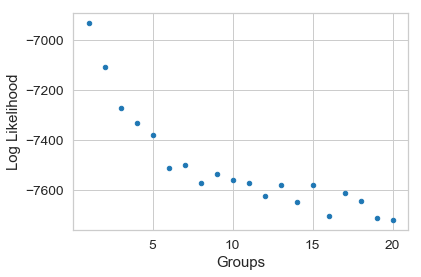

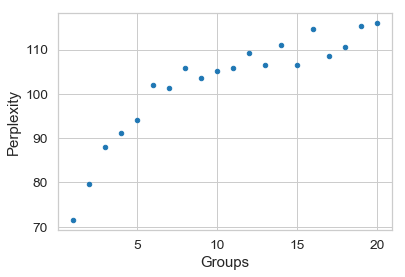

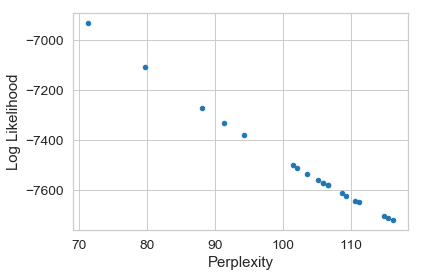

In [84]:
best_groups(20)

In [85]:
lda_model_el_st = LatentDirichletAllocation(n_components = 5)

In [86]:
lda_model_el_st.fit(frequency_el_st)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [87]:
print("Log Likelihood: ", lda_model_el_st.score(frequency_el_st))

print("Perplexity: ", lda_model_el_st.perplexity(frequency_el_st))

Log Likelihood:  -7430.860250091695
Perplexity:  97.09140587094161


In [88]:
pyLDAvis.enable_notebook()
panel_el_st = pyLDAvis.sklearn.prepare(lda_model_el_st, frequency_el_st, vectorizer_el_st, mds='tsne')
panel_el_st

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
2       2.462138  -59.703102       1        1  22.882619
3      12.922141 -108.473198       2        1  22.297531
0      58.495747  -92.724052       3        1  19.526328
4      40.450882  -30.240705       4        1  18.024554
1      85.086884  -52.501350       5        1  17.268968, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
44    Default  75.000000            pd  75.000000  30.0000  30.0000
55    Default  67.000000         renzi  67.000000  29.0000  29.0000
78    Default  53.000000          voto  53.000000  28.0000  28.0000
26    Default  59.000000        italia  59.000000  27.0000  27.0000
6     Default  54.000000    berlusconi  54.000000  26.0000  26.0000
57    Default  44.000000          roma  44.000000  25.0000  25.0000
11    Default  30.000000          così  30.000000  24.0000  24.0000
58    Default  46.000000       salvini  46.000000  23.0000  23.0000
63    Default  27.000000       sindaco  27.000000  22.0000  22.0000
42    Default  26.000000       partito  26.000000  21.0000  21.0000
15    Default  32.000000      elezioni  32.000000  20.0000  20.0000
39    Default  32.000000           ora  32.000000  19.0000  19.0000
23    Default  40.000000       governo  40.000000  18.0000  18.0000
22    Default  24.000000     gentiloni  24.000000  17.0000  17.0000
33    Default  25.000000          maio  25.000000  16.0000  16.0000
20    Default  24.000000         forza  24.000000  15.0000  15.0000
12    Default  18.000000          dopo  18.000000  14.0000  14.0000
60    Default  17.000000         sfida  17.000000  13.0000  13.0000
68    Default  17.000000        stelle  17.000000  12.0000  12.0000
48    Default  18.000000      politica  18.000000  11.0000  11.0000
71    Default  20.000000            sì  20.000000  10.0000  10.0000
64    Default  16.000000      sinistra  16.000000   9.0000   9.0000
4     Default  16.000000     arrestato  16.000000   8.0000   8.0000
21    Default  19.000000  forza italia  19.000000   7.0000   7.0000
31    Default  33.000000           m5s  33.000000   6.0000   6.0000
14    Default  17.000000    elettorale  17.000000   5.0000   5.0000
61    Default  14.000000       sicilia  14.000000   4.0000   4.0000
46    Default  14.000000       pisapia  14.000000   3.0000   3.0000
17    Default  16.000000        europa  16.000000   2.0000   2.0000
59    Default  15.000000         serve  15.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
76     Topic5  11.625353           via  12.382108   1.6932  -3.1832
45     Topic5  11.624367        piazza  12.381995   1.6931  -3.1833
43     Topic5  11.624118         patto  12.381809   1.6931  -3.1833
62     Topic5  10.587131        silvio  11.343770   1.6872  -3.2767
53     Topic5  10.585645           può  11.343560   1.6871  -3.2769
71     Topic5  17.370098            sì  20.432485   1.5939  -2.7816
5      Topic5  10.366373         basta  14.883302   1.3946  -3.2978
9      Topic5  10.472047  centrodestra  15.790775   1.3455  -3.2877
1      Topic5   6.376559        alfano  10.752849   1.2337  -3.7838
10     Topic5   5.398568         colle  10.825197   1.0605  -3.9503
35     Topic5   9.408122        matteo  19.320055   1.0367  -3.3948
50     Topic5   6.131969         prima  15.619168   0.8213  -3.8229
27     Topic5   5.415782        leader  14.638699   0.7619  -3.9471
7      Topic5   5.287499     candidato  16.314036   0.6296  -3.9710
49     Topic5   5.055882       premier  17.433776   0.5184  -4.0158
2      Topic5   5.481336          anni  22.047986   0.3644  -3.9350
13     Topic5   3.575736           due  16.354893   0.2359  -4.3622
28     Topic5   3.440365          lega  26.332163  -0.2790  -4.4008
18     Topic5   2.484420            ex  29.848743  -0.7298  -4.7263
0      Topic5   0.2093

In [89]:
topic_words_df(lda_model_el_st, vectorizer_el_st).head(10)

,0,1,2,3,4
rank,,,,,
1,salvini,così,pd,italia,voto
2,governo,partito,renzi,m5s,roma
3,maio,dopo,berlusconi,forza,sindaco
4,politica,sì,elezioni,forza italia,gentiloni
5,serve,sinistra,ora,elettorale,stelle
6,raggi,sicilia,migranti,ex,sfida
7,capitale,pisapia,anti,europa,arrestato
8,stato,via,salvini,anni,partiti
9,due,piazza,governo,legge,solo


In [90]:
topics_el_st = lda_model_el_st.transform(frequency_el_st)

In [91]:
pd.DataFrame(topics_el_st).head(10)

,0,1,2,3,4
0,0.100001,0.100001,0.599997,0.100001,0.100001
1,0.066668,0.066669,0.400133,0.399862,0.066668
2,0.100001,0.100002,0.100001,0.599994,0.100002
3,0.399339,0.066668,0.067328,0.066667,0.399998
4,0.399804,0.066668,0.066668,0.066668,0.400192
5,0.200000,0.200000,0.200000,0.200000,0.200000
6,0.100001,0.100002,0.599994,0.100001,0.100002
7,0.200000,0.200000,0.200000,0.200000,0.200000
8,0.399804,0.066668,0.066668,0.066668,0.400192
9,0.100001,0.101572,0.100001,0.598425,0.100001


In [92]:
elections_st['Adjectives'] = elections_st['Titles'].apply(extract_adjectives)

In [93]:
elections_st['Adjectives']

0                        aereo
1                             
2                    primo, ai
3                             
4                        nella
5            semplice, precisa
6           migranti, italiani
7                             
8                        nella
9                             
0                    austriaco
1                             
2                             
3       intensiva, intestinale
4                        video
5                             
6                             
7                  cara, della
8    africani, mezza, federale
9                    Verifiche
0               della, maestra
1              vuote, prossimo
2                     Pubblico
3                             
4                             
5                  della, fame
6                      europee
7                             
8                             
9              della, comunale
               ...            
0                       schifo
1       

In [94]:
vectorizer_el_st2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [95]:
vectorizer_el_st2.fit(elections_st['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [96]:
wf_el_st = vectorizer_el_st2.transform(elections_st['Adjectives'])

In [97]:
df_el_st = pd.DataFrame(wf_el_st.todense(),
                        columns = vectorizer_el_st2.get_feature_names())

In [98]:
df_el_st.sum().sort_values(ascending=False)

ex              30
elettorale      18
anti            14
nuova            7
regionali        7
vero             7
nuovo            7
politica         6
migranti         6
pronti           6
regionale        5
soli             5
sociali          5
civili           5
urne             5
grande           5
elettorali       5
prima            5
doppio           5
comunale         4
giusto           4
voto             4
pronto           4
primo            4
impossibile      4
civile           3
liste            3
possibile        3
camorra          3
sindaca          3
                ..
pugliesi         1
pulci            1
punitia          1
piemontesi       1
piccoli          1
monnezza         1
omosessuali      1
mortale          1
naso             1
nazionali        1
ndrangheta       1
nere             1
neutrale         1
neutre           1
nido             1
notabili         1
note             1
online           1
piccola          1
onorevoli        1
orfana           1
orizzonte   

# c) Il Mattino

In [115]:
elections_mat = search_matt('elezioni', 25)

In [116]:
elections_mat.head()

,0
0,ACCEDI AL MATTINO
1,"Sola e sconfitta: l'addio tra le lacrime della May, la lady di gomma"
2,"Elezioni, l'ultimo duello Salvini-Di Maio: «Lega primo partito», «Ma M5S maggioranza»"
3,"Elezioni europee, i cinque scenari di lunedì"
4,I cinque scenari di lunedì


In [117]:
elections_mat.tail()

,0
44,Tredicenne di origini brasiliane picchiata dalle baby bulle Il raid in un video
45,"Elezioni, ultimo duello Salvini-Di Maio: «Lega prima», «M5S maggioranza»"
46,"Ernesto a Foria, ritorno solidale"
47,"Weekend a Napoli, ecco tutti gli eventi"
48,L'amarcord di Piero Mastroberardino


In [118]:
elections_mat.describe()

,0
count,1225
unique,1004
top,"Weekend a Napoli, ecco tutti gli eventi"
freq,25


In [119]:
elections_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 48
Data columns (total 1 columns):
0    1225 non-null object
dtypes: object(1)
memory usage: 19.1+ KB


In [120]:
elections_mat = elections_mat.rename(columns = {0:"Titles"})

In [121]:
elections_mat['word_numb'] = elections_mat['Titles'].apply(word_count)

In [122]:
elections_mat['word_numb'].describe()

count    1225.000000
mean       10.351020
std         3.178135
min         3.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

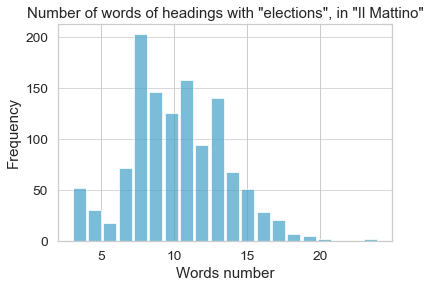

In [123]:
n, bins, patches = plt.hist(x=elections_mat['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "elections", in "Il Mattino"''')
maxfreq = n.max()

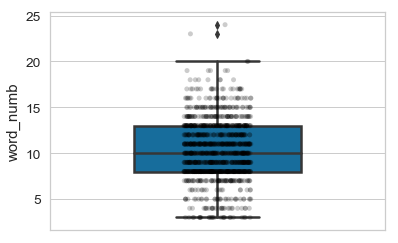

In [124]:
sns.boxplot(y = 'word_numb', 
                 data = elections_mat, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = elections_mat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [125]:
vectorizer_el_mat = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 0.99,
                             min_df    = 0.01)

In [126]:
vectorizer_el_mat.fit(elections_mat['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [127]:
len(vectorizer_el_mat.get_feature_names())

92

In [128]:
vectorizer_el_mat.get_feature_names()[0:10]

['10',
 '2019',
 'accedi',
 'addio',
 'amarcord',
 'anni',
 'avellino',
 'avvocati',
 'baby',
 'berlusconi']

In [129]:
frequency_el_mat = vectorizer_el_mat.transform(elections_mat['Titles'])

In [130]:
frequency_el_mat

<1225x92 sparse matrix of type '<class 'numpy.int64'>'
	with 3562 stored elements in Compressed Sparse Row format>

In [131]:
wordfreq_el_mat = pd.DataFrame(frequency_el_mat.toarray(),
                            columns = vectorizer_el_mat.get_feature_names(),
                            index = elections_mat.index)

In [132]:
wordfreq_el_mat.head()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
wordfreq_el_mat.tail()

,10,2019,accedi,addio,amarcord,anni,avellino,avvocati,baby,berlusconi,...,treni,tria,ue,ultimo,venezuela,via,video,voto,weekend,zingaretti
44,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
48,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
wordfreq_el_mat.sum().sort_values(ascending=False)[:20]

elezioni       282
candidati      198
comunali       188
2019           184
liste          153
salvini        129
napoli          92
lega            92
maio            89
m5s             84
europee         78
voto            52
governo         50
italia          43
prima           36
solo            36
pd              36
maggioranza     33
conte           33
giorno          31
dtype: int64

In [167]:
df_freq_el_mat = wordfreq_el_mat.sum().sort_values(ascending=False)[:20]

In [168]:
pd.DataFrame(df_freq_el_mat)

,0
elezioni,282
candidati,198
comunali,188
2019,184
liste,153
salvini,129
napoli,92
lega,92
maio,89
m5s,84


In [169]:
df_freq_el_mat.to_csv('freq_el_mat.csv')

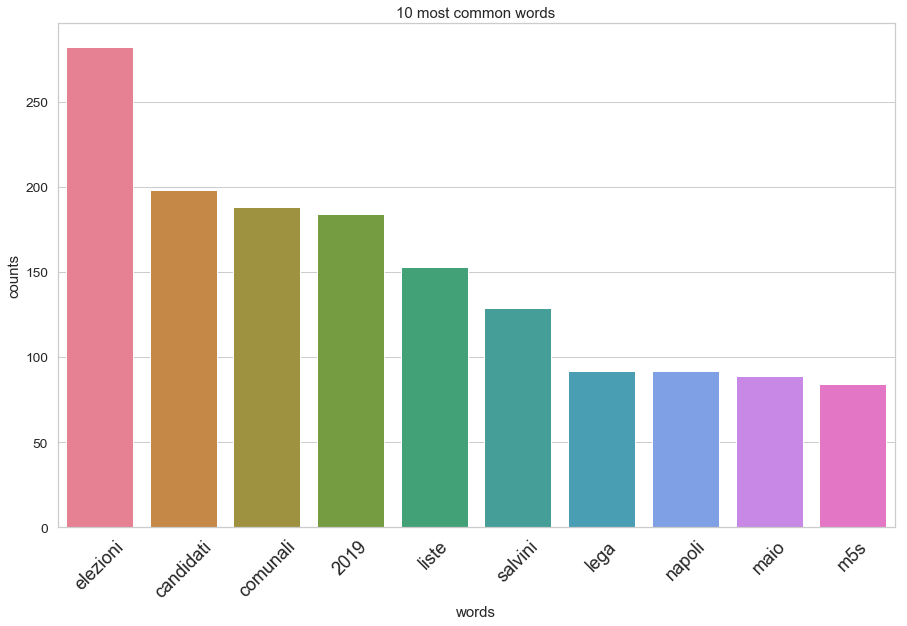

In [160]:
plot_10_most_common_words(frequency_el_mat, vectorizer_el_mat)

Latent Dirichlet Allocation

In [136]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_el_mat = LatentDirichletAllocation(n_components = model)
        lda_model_el_mat.fit(frequency_el_mat)
        loglik = lda_model_el_mat.score(frequency_el_mat)
        perpl = lda_model_el_mat.perplexity(frequency_el_mat)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-14926.809252,65.905249
1,2,-14390.456154,56.697277
2,3,-13987.623514,50.637781
3,4,-13779.508514,47.765532
4,5,-13756.535342,47.458631
5,6,-13229.689927,40.936996
6,7,-13284.197071,41.567891
7,8,-13054.756095,38.976178
8,9,-13160.242160,40.147024
9,10,-12908.447315,37.408532


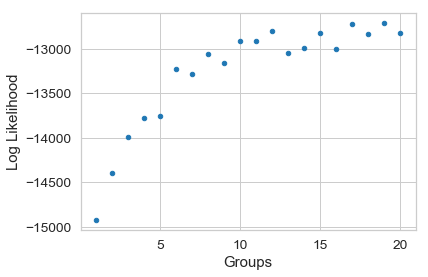

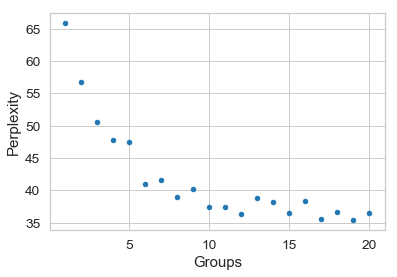

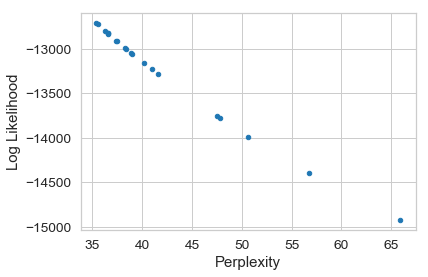

In [137]:
best_groups(20)

In [138]:
lda_model_el_mat = LatentDirichletAllocation(n_components = 5)

In [139]:
lda_model_el_mat.fit(frequency_el_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [140]:
print("Log Likelihood: ", lda_model_el_mat.score(frequency_el_mat))

print("Perplexity: ", lda_model_el_mat.perplexity(frequency_el_mat))

Log Likelihood:  -13348.260242059569
Perplexity:  42.321832947286765


In [141]:
print(lda_model_el_mat.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [142]:
pyLDAvis.enable_notebook()
panel_el_mat = pyLDAvis.sklearn.prepare(lda_model_el_mat, frequency_el_mat, vectorizer_el_mat, mds='tsne')
panel_el_mat

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      121.554466  211.463730       1        1  29.456928
2      318.252930 -566.593933       2        1  20.509698
0     -457.230255   97.987358       3        1  17.165171
4      646.945068  -53.461193       4        1  16.657710
1     -262.378571 -478.775269       5        1  16.210493, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
14    Default  184.000000        candidati  184.000000  30.0000  30.0000
20    Default  175.000000         comunali  175.000000  29.0000  29.0000
1     Default  171.000000             2019  171.000000  28.0000  28.0000
68    Default  124.000000          salvini  124.000000  27.0000  27.0000
29    Default  263.000000         elezioni  263.000000  26.0000  26.0000
43    Default  142.000000            liste  142.000000  25.0000  25.0000
32    Default   79.000000          europee   79.000000  24.0000  24.0000
41    Default   88.000000             lega   88.000000  23.0000  23.0000
46    Default   85.000000             maio   85.000000  22.0000  22.0000
44    Default   81.000000              m5s   81.000000  21.0000  21.0000
52    Default   92.000000           napoli   92.000000  20.0000  20.0000
38    Default   51.000000          governo   51.000000  19.0000  19.0000
39    Default   44.000000           italia   44.000000  18.0000  18.0000
89    Default   50.000000             voto   50.000000  17.0000  17.0000
76    Default   37.000000             solo   37.000000  16.0000  16.0000
59    Default   37.000000               pd   37.000000  15.0000  15.0000
11    Default   32.000000           brexit   32.000000  14.0000  14.0000
24    Default   32.000000               de   32.000000  13.0000  13.0000
37    Default   32.000000           giorno   32.000000  12.0000  12.0000
48    Default   32.000000       mattarella   32.000000  11.0000  11.0000
3     Default   31.000000            addio   31.000000  10.0000  10.0000
66    Default   31.000000             resa   31.000000   9.0000   9.0000
63    Default   35.000000            prima   35.000000   8.0000   8.0000
67    Default   30.000000          ritorno   30.000000   7.0000   7.0000
64    Default   30.000000           pronti   30.000000   6.0000   6.0000
54    Default   30.000000            nuovi   30.000000   5.0000   5.0000
51    Default   30.000000             mesi   30.000000   4.0000   4.0000
42    Default   30.000000            linea   30.000000   3.0000   3.0000
88    Default   29.000000            video   29.000000   2.0000   2.0000
72    Default   29.000000            sette   29.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
8      Topic5   26.535491             baby   27.318308   1.7904  -3.0806
60     Topic5   25.522831        picchiata   26.305505   1.7893  -3.1196
58     Topic5   25.522831          origini   26.305505   1.7893  -3.1196
81     Topic5   25.522831       tredicenne   26.305505   1.7893  -3.1196
10     Topic5   25.522831       brasiliane   26.305505   1.7893  -3.1196
12     Topic5   25.522831            bulle   26.305505   1.7893  -3.1196
61     Topic5   25.522812            piero   26.305505   1.7893  -3.1196
4      Topic5   25.522812         amarcord   26.305505   1.7893  -3.1196
47     Topic5   25.522812  mastroberardino   26.305505   1.7893  -3.1196
74     Topic5   23.495241          sindaco   24.279790   1.7867  -3.2023
50     Topic5   19.444686              may   20.228606   1.7800  -3.3916
34     Topic5   19.441821               ex   20.228586   1.7798  -3.3917
36     Topic5   18.431608            forza   19.215795   1.7778  -3.4451
80     Topic5   14.379658            torna   15.164539   1.7664  -3.6933
15     Topic5   13.366245        candidato   14.151678   1.7624  -3.7664
78     Topic5    8.996088              sud   16

In [143]:
topic_words_df(lda_model_el_mat, vectorizer_el_mat).head(10)

,0,1,2,3,4
rank,,,,,
1,napoli,italia,salvini,elezioni,europee
2,giorno,brexit,lega,candidati,governo
3,mattarella,de,maio,comunali,solo
4,addio,video,m5s,2019,pd
5,resa,raid,elezioni,liste,nuovi
6,ritorno,berlusconi,voto,mattino,pronti
7,sette,baby,prima,napoli,mesi
8,omaggio,tredicenne,maggioranza,weekend,linea
9,italiana,brasiliane,duello,eventi,10


In [144]:
topics_el_mat = lda_model_el_mat.transform(frequency_el_mat)

In [145]:
pd.DataFrame(topics_el_mat).head(10)

,0,1,2,3,4
0,0.066667,0.066667,0.066667,0.733331,0.066667
1,0.400026,0.399972,0.066667,0.066667,0.066668
2,0.022222,0.022222,0.910908,0.022425,0.022222
3,0.066667,0.066667,0.067620,0.399043,0.400003
4,0.200000,0.200000,0.200000,0.200000,0.200000
5,0.066667,0.066667,0.733332,0.066667,0.066667
6,0.200000,0.200000,0.200000,0.200000,0.200000
7,0.599217,0.100000,0.100000,0.100782,0.100000
8,0.050001,0.050001,0.347304,0.502694,0.050001
9,0.100000,0.599998,0.100000,0.100000,0.100001


In [146]:
elections_mat['Adjectives'] = elections_mat['Titles'].apply(extract_adjectives)

In [147]:
elections_mat['Adjectives']

0                                         AL
1                     Sola, sconfitta, della
2                              ultimo, primo
3                                    europee
4                                           
5                                      vinco
6                                           
7                                        nei
8     campano, libera, dal, direttivo, della
9                                           
10                                          
11                                elettorale
12                     comune, camorristiche
13                                    Grande
14              dimenticato, della, politica
15                            Europee, primi
16                                   Europee
17                                    giusta
18                                     primo
19                   Europee, impresentabili
20                                          
21                                   camorra
22        

In [148]:
vectorizer_el_mat2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [149]:
vectorizer_el_mat2.fit(elections_mat['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [150]:
wf_el_mat = vectorizer_el_mat2.transform(elections_mat['Adjectives'])

In [151]:
df_el_mat = pd.DataFrame(wf_el_mat.todense(),
                        columns = vectorizer_el_mat2.get_feature_names())

In [152]:
df_el_mat.sum().sort_values(ascending=False)

comunali        180
europee          32
ultimo           30
nuovi            29
pronti           29
italiana         26
solidale         26
bulle            25
brasiliane       25
nuovo            25
ex               19
elettorale       10
anti              9
primo             8
regionali         8
pronto            7
grande            7
urne              7
leghista          6
libera            6
doppio            5
alta              5
prima             5
politica          5
pronta            5
social            5
nuova             4
migranti          4
legittima         4
elettorali        4
               ... 
polemiche         1
politiche         1
post              1
pratica           1
preoccupata       1
preoccupato       1
primarie          1
prioriaria        1
probabili         1
palco             1
pacifiche         1
pacchetto         1
netto             1
natali            1
necessario        1
negativo          1
nemica            1
neo               1
neomelodica       1


# Topic word 2: 'Europa'

# a) La Repubblica

In [137]:
europe_rep = search_rep('Europa', 100)

In [139]:
europe_rep.head()

,0
0,La nostra Europa/ 7
1,no titolo
2,"Europa League Pari Chelsea, l’Arsenal ride"
3,La nostra Europa/6
4,"Candidati di destra in ""Europa verde"", Civati ..."


In [140]:
europe_rep.tail()

,0
5,Province
6,Teatri
7,Ravenna
8,E-COMMERCE E FARMACIE: IL PUNTO IN UN CONVEGNO
9,Accademia delle Scienze Mediterraneo


In [141]:
europe_rep.describe()

,0
count,1021
unique,859
top,no titolo
freq,35


In [143]:
europe_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 0 to 9
Data columns (total 1 columns):
0    1021 non-null object
dtypes: object(1)
memory usage: 16.0+ KB


In [144]:
europe_rep = europe_rep.rename(columns = {0:"Titles"})

In [145]:
europe_rep['word_numb'] = europe_rep['Titles'].apply(word_count)

In [146]:
europe_rep['word_numb'].describe()

count    1021.000000
mean        7.438786
std         4.171498
min         0.000000
25%         4.000000
50%         8.000000
75%        10.000000
max        24.000000
Name: word_numb, dtype: float64

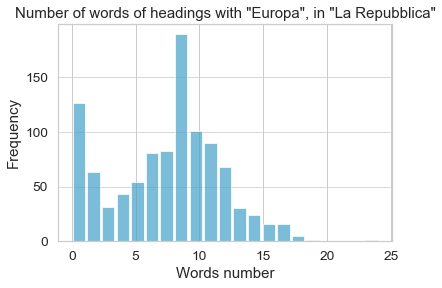

In [288]:
n, bins, patches = plt.hist(x=europe_rep['word_numb'], bins='auto', color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "La Repubblica"''')
maxfreq = n.max()

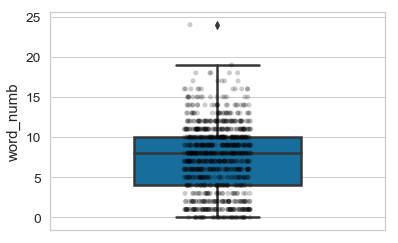

In [265]:
sns.boxplot(y = 'word_numb', 
                 data = europe_rep, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_rep, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [148]:
vectorizer_eu_rep = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [149]:
vectorizer_eu_rep.fit(europe_rep['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [150]:
len(vectorizer_eu_rep.get_feature_names())

32

In [151]:
vectorizer_eu_rep.get_feature_names()[0:10]

['anni',
 'bologna',
 'catania',
 'champions',
 'città',
 'così',
 'dopo',
 'europa',
 'europee',
 'festival']

In [152]:
frequency_eu_rep = vectorizer_eu_rep.transform(europe_rep['Titles'])

In [153]:
frequency_eu_rep

<1021x32 sparse matrix of type '<class 'numpy.int64'>'
	with 624 stored elements in Compressed Sparse Row format>

In [154]:
wordfreq_eu_rep = pd.DataFrame(frequency_eu_rep.toarray(),
                            columns = vectorizer_eu_rep.get_feature_names(),
                            index = europe_rep.index)

In [155]:
wordfreq_eu_rep.head()

,anni,bologna,catania,champions,città,così,dopo,europa,europee,festival,...,ravenna,salvini,sfida,sinistra,solo,toro,tre,ue,usa,zingaretti
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
wordfreq_eu_rep.tail()

,anni,bologna,catania,champions,città,così,dopo,europa,europee,festival,...,ravenna,salvini,sfida,sinistra,solo,toro,tre,ue,usa,zingaretti
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
wordfreq_eu_rep.sum().sort_values(ascending=False)[:20]

europa        164
italia         27
bologna        21
zingaretti     19
salvini        19
ora            19
così           19
ue             19
pd             18
città          16
migranti       16
sfida          15
sinistra       15
province       15
solo           15
maggio         15
lega           14
prima          14
dopo           13
napoli         13
dtype: int64

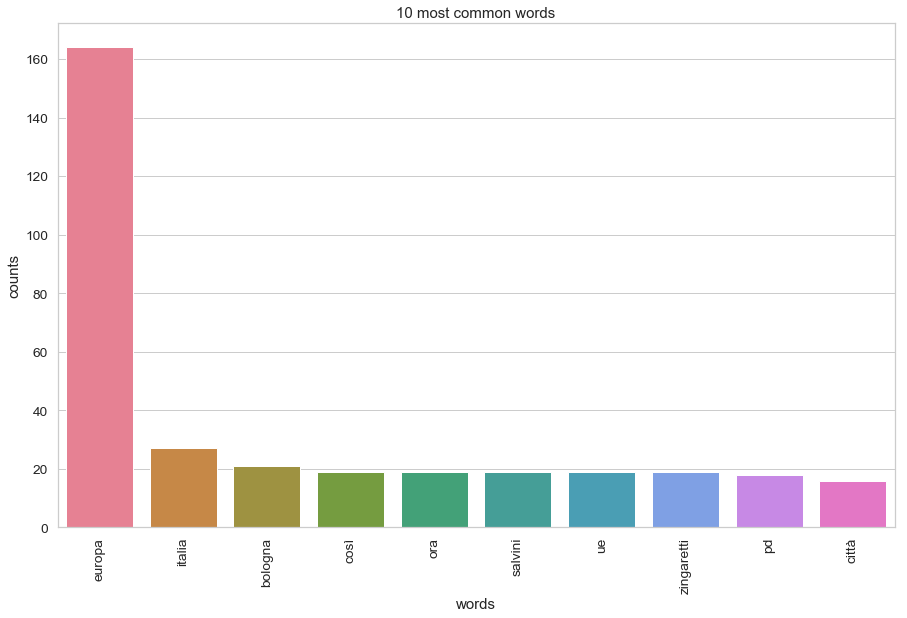

In [158]:
plot_10_most_common_words(frequency_eu_rep, vectorizer_eu_rep)

In [159]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_rep = LatentDirichletAllocation(n_components = model)
        lda_model_eu_rep.fit(frequency_eu_rep)
        loglik = lda_model_eu_rep.score(frequency_eu_rep)
        perpl = lda_model_eu_rep.perplexity(frequency_eu_rep)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-1982.282452,23.846845
1,2,-2069.917124,27.436312
2,3,-2089.901814,28.327779
3,4,-2172.153393,32.312218
4,5,-2181.471679,32.797579
5,6,-2191.957253,33.352462
6,7,-2274.485990,38.060522
7,8,-2238.886574,35.953215
8,9,-2278.349798,38.296545
9,10,-2297.646707,39.497395


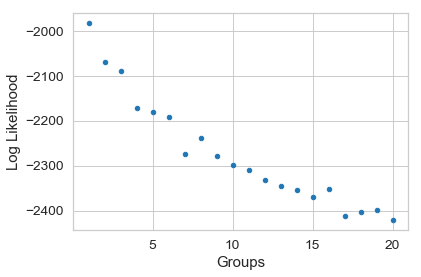

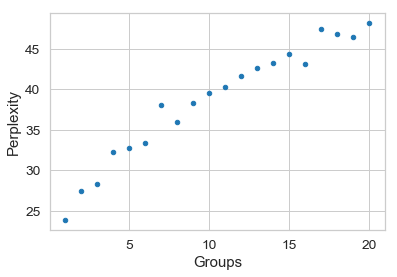

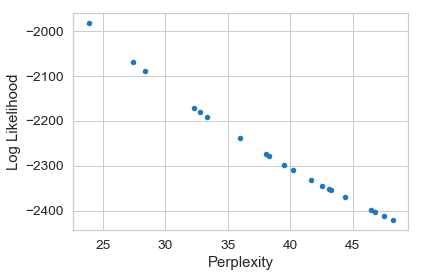

In [160]:
best_groups(20)

In [161]:
lda_model_eu_rep = LatentDirichletAllocation(n_components = 3)

In [162]:
lda_model_eu_rep.fit(frequency_eu_rep)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [163]:
print("Log Likelihood: ", lda_model_eu_rep.score(frequency_eu_rep))

print("Perplexity: ", lda_model_eu_rep.perplexity(frequency_eu_rep))

Log Likelihood:  -2115.472389672513
Perplexity:  29.510785995187067


In [164]:
print(lda_model_eu_rep.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [165]:
pyLDAvis.enable_notebook()
panel_eu_rep = pyLDAvis.sklearn.prepare(lda_model_eu_rep, frequency_eu_rep, vectorizer_eu_rep, mds='tsne')
panel_eu_rep

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      -632.045471 -384.325073       1        1  37.554983
1     -1209.665405  212.164124       2        1  33.384930
2     -1437.453247 -586.322510       3        1  29.060087, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
7     Default  143.000000      europa  143.000000  30.0000  30.0000
11    Default   27.000000      italia   27.000000  29.0000  29.0000
1     Default   22.000000     bologna   22.000000  28.0000  28.0000
18    Default   20.000000         ora   20.000000  27.0000  27.0000
5     Default   20.000000        così   20.000000  26.0000  26.0000
21    Default   16.000000    province   16.000000  25.0000  25.0000
13    Default   16.000000      maggio   16.000000  24.0000  24.0000
26    Default   16.000000        solo   16.000000  23.0000  23.0000
19    Default   18.000000          pd   18.000000  22.0000  22.0000
15    Default   14.000000      napoli   14.000000  21.0000  21.0000
29    Default   19.000000          ue   19.000000  20.0000  20.0000
3     Default   13.000000   champions   13.000000  19.0000  19.0000
28    Default   13.000000         tre   13.000000  18.0000  18.0000
25    Default   15.000000    sinistra   15.000000  17.0000  17.0000
24    Default   15.000000       sfida   15.000000  16.0000  16.0000
23    Default   17.000000     salvini   17.000000  15.0000  15.0000
31    Default   17.000000  zingaretti   17.000000  14.0000  14.0000
12    Default   14.000000        lega   14.000000  13.0000  13.0000
20    Default   14.000000       prima   14.000000  12.0000  12.0000
2     Default   12.000000     catania   12.000000  11.0000  11.0000
0     Default   12.000000        anni   12.000000  10.0000  10.0000
30    Default   13.000000         usa   13.000000   9.0000   9.0000
22    Default   12.000000     ravenna   12.000000   8.0000   8.0000
9     Default   12.000000    festival   12.000000   7.0000   7.0000
4     Default   14.000000       città   14.000000   6.0000   6.0000
14    Default   14.000000    migranti   14.000000   5.0000   5.0000
10    Default   12.000000      futuro   12.000000   4.0000   4.0000
17    Default   11.000000        oggi   11.000000   3.0000   3.0000
16    Default   11.000000       nuovo   11.000000   2.0000   2.0000
8     Default   11.000000     europee   11.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
5      Topic3   20.189968        così   20.822330   1.2050  -2.1968
21     Topic3   16.023900    province   16.642960   1.1979  -2.4279
13     Topic3   16.015671      maggio   16.641716   1.1975  -2.4284
26     Topic3   15.998239        solo   16.640378   1.1965  -2.4295
15     Topic3   13.918648      napoli   14.550926   1.1914  -2.5687
3      Topic3   12.873942   champions   13.505640   1.1879  -2.6467
28     Topic3   12.872741         tre   13.505065   1.1879  -2.6468
2      Topic3   11.842845     catania   12.461919   1.1849  -2.7302
0      Topic3   11.828353        anni   12.459773   1.1838  -2.7314
27     Topic3    0.371435        toro   10.526457  -2.1085  -6.1923
6      Topic3    0.394874        dopo   12.269274  -2.2005  -6.1311
8      Topic3    0.363026     europee   11.735390  -2.2401  -6.2152
16     Topic3    0.359014       nuovo   11.734823  -2.2512  -6.2263
17     Topic3    0.353452        oggi   11.735056  -2.2668  -6.2420
10     Topic3    0.370034      futuro   12.712803  -2.3010  -6.1961
22     Topic3    0.351287     ravenna   12.714814  -2.3531  -6.2481
9      Topic3    0.351157    festival   12.714502  -2.3535  -6.2485
30     Topic3    0.351013         usa   13.691590  -2.4279  -6.2489
20     Topic3    0.369921       prima   14.674139  -2.4447  -6.1964
4      Topic3    0.361799       città   14.869555  -2.4802  -6.2186
14     Topic3    0.356405    migranti   14.869485  -2.4952

In [166]:
topic_words_df(lda_model_eu_rep, vectorizer_eu_rep).head(10)

,0,1,2
rank,,,
1,europa,italia,bologna
2,salvini,pd,ora
3,zingaretti,ue,così
4,città,sinistra,province
5,migranti,sfida,maggio
6,dopo,lega,solo
7,toro,prima,napoli
8,ue,usa,champions
9,futuro,ravenna,tre


In [167]:
topics_eu_rep = lda_model_eu_rep.transform(frequency_eu_rep)

In [168]:
pd.DataFrame(topics_eu_rep).head(10)

,0,1,2
0,0.666645,0.166677,0.166678
1,0.333333,0.333333,0.333333
2,0.666645,0.166677,0.166678
3,0.666645,0.166677,0.166678
4,0.666645,0.166677,0.166678
5,0.666645,0.166677,0.166678
6,0.666645,0.166677,0.166678
7,0.666645,0.166677,0.166678
8,0.445606,0.443183,0.111211
9,0.777667,0.111158,0.111176


In [169]:
europe_rep['Adjectives'] = europe_rep['Titles'].apply(extract_adjectives)

In [170]:
europe_rep['Adjectives']

0                               
1                               
2                               
3                               
4                          verde
5                         giusta
6                               
7                               
8                               
9                               
0                               
1                     sovranista
2                               
3                    traballante
4                               
5                               
6            ricette, apprezzate
7                          reali
8                               
9                               
0                               
1                    UN, NON, SI
2                               
3                               
4                         pronta
5                               
6                            Nel
7                               
8                               
9                               
          

In [171]:
vectorizer_eu_rep2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [172]:
vectorizer_eu_rep2.fit(europe_rep['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [173]:
wf_eu_rep = vectorizer_eu_rep2.transform(europe_rep['Adjectives'])

In [174]:
df_eu_rep = pd.DataFrame(wf_eu_rep.todense(),
                        columns = vectorizer_eu_rep2.get_feature_names())

In [175]:
df_eu_rep.sum().sort_values(ascending=False)

grande        10
nuovo          9
prima          9
migranti       8
altra          8
nuovi          6
ultimo         5
italiani       5
primo          4
anti           4
nuova          4
ultima         4
finale         4
azzurro        3
elettrica      3
sovranista     3
nero           3
forte          3
secondo        3
cinesi         3
pronta         3
europei        3
ex             3
elettorale     3
europeo        3
vera           3
ii             3
umani          2
bianco         2
lontana        2
              ..
partigiano     1
patria         1
pazzo          1
pericolosa     1
offensivo      1
pericolosi     1
pesca          1
piccole        1
piemontese     1
pole           1
politica       1
olimpico       1
odiosa         1
memorabile     1
moro           1
memoria        1
meticcia       1
mezza          1
moderno        1
mondiale       1
morale         1
murale         1
nuove          1
nazionali      1
nera           1
neri           1
notturne       1
nucleare      

# b) La Stampa

In [177]:
europe_st = search_stampa('Europa', 100)

In [178]:
europe_st.head()

,0
0,Almeno 70 morti in un naufragio al largo della...
1,Le tangenti in Lombardia travolgono Forza Ital...
2,"Violazione della privacy, in un anno 8 milioni..."
3,Salvini al cancelliere austriaco Kurz: “Non pu...
4,A Napoli la prossima tappa degli Hard-Talk del...


In [179]:
europe_st.tail()

,0
5,Così lo Stato dimentica le vittime di femminic...
6,La più grande industria è il riciclaggio di de...
7,Gomorra ha messo le mani anche sui sacchetti d...
8,Quel clamoroso abbaglio sul superboss dei traf...
9,Il mercante di esseri umani che crede di esser...


In [180]:
europe_st.describe()

,0
count,1000
unique,998
top,Fassino: “Siamo pronti ad aiutarli. Ma ora i r...
freq,2


In [181]:
europe_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 9
Data columns (total 1 columns):
0    1000 non-null object
dtypes: object(1)
memory usage: 15.6+ KB


In [182]:
europe_st = europe_st.rename(columns = {0:"Titles"})

In [183]:
europe_st['word_numb'] = europe_st['Titles'].apply(word_count)

In [184]:
europe_st['word_numb'].describe()

count    1000.000000
mean       11.076000
std         3.011527
min         3.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        24.000000
Name: word_numb, dtype: float64

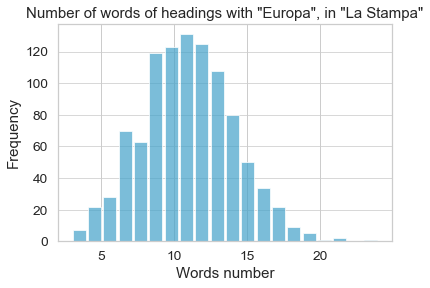

In [290]:
n, bins, patches = plt.hist(x=europe_st['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "La Stampa"''')
maxfreq = n.max()

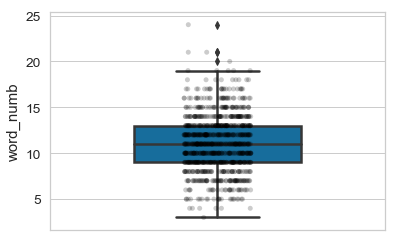

In [266]:
sns.boxplot(y = 'word_numb', 
                 data = europe_st, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_st, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [186]:
vectorizer_eu_st = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             ngram_range = (1,2),
                             max_df    = 0.99,
                             min_df    = 0.01)

In [187]:
vectorizer_eu_st.fit(europe_st['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [188]:
vectorizer_eu_st.get_feature_names()[0:10]

['40',
 '50',
 'allarme',
 'anni',
 'anno',
 'arresti',
 'arriva',
 'bambini',
 'battaglia',
 'bruxelles']

In [189]:
frequency_eu_st = vectorizer_eu_st.transform(europe_st['Titles'])

In [190]:
frequency_eu_st

<1000x64 sparse matrix of type '<class 'numpy.int64'>'
	with 1209 stored elements in Compressed Sparse Row format>

In [191]:
wordfreq_eu_st = pd.DataFrame(frequency_eu_st.toarray(),
                            columns = vectorizer_eu_st.get_feature_names(),
                            index = europe_st.index)

In [192]:
wordfreq_eu_st.head()

,40,50,allarme,anni,anno,arresti,arriva,bambini,battaglia,bruxelles,...,sea watch,sempre,solo,stato,sud,sì,tre,ue,via,watch
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
wordfreq_eu_st.tail()

,40,50,allarme,anni,anno,arresti,arriva,bambini,battaglia,bruxelles,...,sea watch,sempre,solo,stato,sud,sì,tre,ue,via,watch
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
wordfreq_eu_st.sum().sort_values(ascending=False)[:20]

italia      138
europa       82
migranti     66
ue           42
così         40
roma         36
anni         28
italiani     26
milano       24
salvini      23
governo      23
nord         23
ora          22
due          21
euro         20
m5s          18
anno         18
milioni      17
renzi        17
record       17
dtype: int64

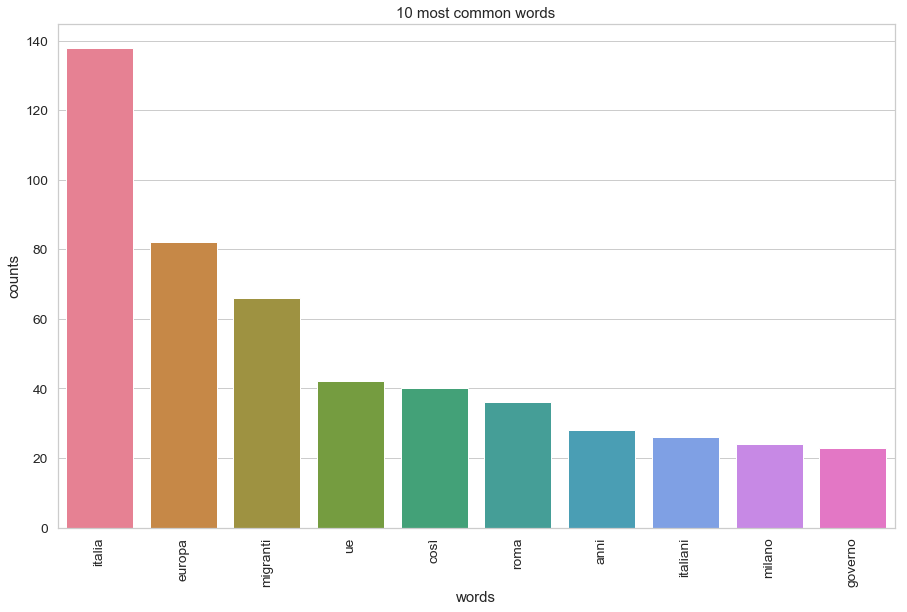

In [195]:
plot_10_most_common_words(frequency_eu_st, vectorizer_eu_st)

In [196]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_st = LatentDirichletAllocation(n_components = model)
        lda_model_eu_st.fit(frequency_eu_st)
        loglik = lda_model_eu_st.score(frequency_eu_st)
        perpl = lda_model_eu_st.perplexity(frequency_eu_st)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-4784.562719,51.983109
1,2,-4909.651569,57.639765
2,3,-5069.617227,65.779389
3,4,-5149.683923,70.275465
4,5,-5204.592940,73.535230
5,6,-5204.853941,73.551080
6,7,-5244.405752,75.992951
7,8,-5324.817396,81.210262
8,9,-5295.438519,79.263806
9,10,-5358.928392,83.530283


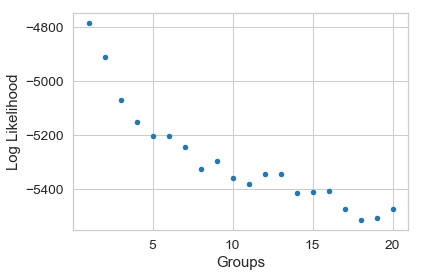

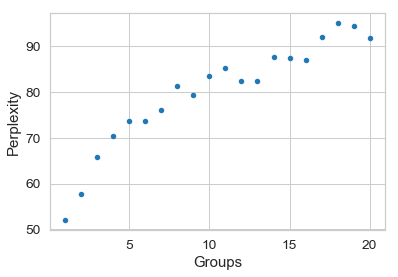

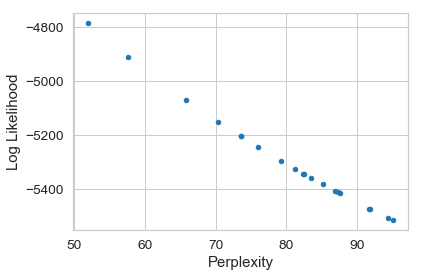

In [197]:
best_groups(20)

In [199]:
lda_model_eu_st = LatentDirichletAllocation(n_components = 6)

In [200]:
lda_model_eu_st.fit(frequency_eu_st)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [201]:
print("Log Likelihood: ", lda_model_eu_st.score(frequency_eu_st))

print("Perplexity: ", lda_model_eu_st.perplexity(frequency_eu_st))

Log Likelihood:  -5280.08029704386
Perplexity:  78.26490863409303


In [202]:
pyLDAvis.enable_notebook()
panel_eu_st = pyLDAvis.sklearn.prepare(lda_model_eu_st, frequency_eu_st, vectorizer_eu_st, mds='tsne')
panel_eu_st

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       19.952755   56.268085       1        1  21.298414
3      362.834229    1.474139       2        1  20.371266
4     -289.646088 -100.939026       3        1  15.604407
2       73.805046 -286.759521       4        1  15.553915
0     -225.224991  302.144806       5        1  15.120092
5      178.030823  365.427856       6        1  12.051906, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
24    Default  123.000000     italia  123.000000  30.0000  30.0000
31    Default   58.000000   migranti   58.000000  29.0000  29.0000
61    Default   43.000000         ue   43.000000  28.0000  28.0000
13    Default   38.000000       così   38.000000  27.0000  27.0000
18    Default   73.000000     europa   73.000000  26.0000  26.0000
49    Default   36.000000       roma   36.000000  25.0000  25.0000
39    Default   25.000000        ora   25.000000  24.0000  24.0000
3     Default   29.000000       anni   29.000000  23.0000  23.0000
28    Default   21.000000        m5s   21.000000  22.0000  22.0000
25    Default   26.000000   italiani   26.000000  21.0000  21.0000
16    Default   22.000000        due   22.000000  20.0000  20.0000
15    Default   18.000000       dopo   18.000000  19.0000  19.0000
33    Default   22.000000     milano   22.000000  18.0000  18.0000
36    Default   23.000000       nord   23.000000  17.0000  17.0000
40    Default   14.000000      paese   14.000000  16.0000  16.0000
50    Default   22.000000    salvini   22.000000  15.0000  15.0000
42    Default   15.000000         pd   15.000000  14.0000  14.0000
58    Default   15.000000        sud   15.000000  13.0000  13.0000
5     Default   13.000000    arresti   13.000000  12.0000  12.0000
14    Default   13.000000      donne   13.000000  11.0000  11.0000
17    Default   20.000000       euro   20.000000  10.0000  10.0000
37    Default   14.000000      nuova   14.000000   9.0000   9.0000
47    Default   16.000000      renzi   16.000000   8.0000   8.0000
23    Default   21.000000    governo   21.000000   7.0000   7.0000
57    Default   12.000000      stato   12.000000   6.0000   6.0000
19    Default   14.000000         fa   14.000000   5.0000   5.0000
34    Default   17.000000    milioni   17.000000   4.0000   4.0000
7     Default   11.000000    bambini   11.000000   3.0000   3.0000
43    Default   11.000000     piazza   11.000000   2.0000   2.0000
10    Default   11.000000     caccia   11.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
55     Topic6    2.410826     sempre   12.594403   0.4627  -4.1033
62     Topic6    2.410212        via   13.533865   0.3905  -4.1035
35     Topic6    0.186259      morti    9.762047  -1.8432  -6.6639
54     Topic6    0.185943  sea watch    9.761933  -1.8449  -6.6656
53     Topic6    0.185943        sea    9.761933  -1.8449  -6.6656
63     Topic6    0.185943      watch    9.761933  -1.8449  -6.6656
27     Topic6    0.185796     lavoro    9.762020  -1.8457  -6.6664
8      Topic6    0.187115  battaglia    9.842876  -1.8468  -6.6593
6      Topic6    0.185806     arriva   10.050726  -1.8748  -6.6663
26     Topic6    0.185794   italiano   10.365636  -1.9057  -6.6664
59     Topic6    0.186580         sì   10.473025  -1.9117  -6.6621
38     Topic6    0.186257       ogni   10.504343  -1.9165  -6.6639
0      Topic6    0.186135         40   10.784707  -1.9435  -6.6645
52     Topic6    0.185795     scuola   10.921795  -1.9579  -6.6664
21     Topic6    0.186082  gentiloni   10.942730  -1.9583  -6.6648
48     Topic6    0.185794    rischio   10.942620  -1.9598  -6.6664
44     Topic6    0.185794      prima   10.942682  -1.9598  -6.6664
20     Topic6    0.186123       fuga   11.064089  -1.9691  -6.6646
7      Topic6    0.186251    bambini   11.305263  -1.9900  -6.6639
10     To

In [203]:
topic_words_df(lda_model_eu_st, vectorizer_eu_st).head(10)

,0,1,2,3,4,5
rank,,,,,,
1,roma,migranti,così,italia,ue,ora
2,pd,europa,salvini,europa,anni,m5s
3,sud,milano,euro,renzi,italiani,dopo
4,milioni,governo,stato,fa,due,paese
5,centro,tre,via,paura,nord,arresti
6,gentiloni,record,bambini,allarme,nuova,donne
7,prima,sea watch,piazza,battaglia,scuola,50
8,rischio,sea,caccia,bruxelles,ogni,ragazzi
9,scontro,watch,sempre,milioni,50,tre


In [204]:
topics_eu_st = lda_model_eu_st.transform(frequency_eu_st)

In [205]:
pd.DataFrame(topics_eu_st).head(10)

,0,1,2,3,4,5
0,0.083334,0.583331,0.083334,0.083334,0.083334,0.083334
1,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333
2,0.721178,0.056103,0.055704,0.055823,0.055636,0.055556
3,0.055831,0.055556,0.388595,0.388907,0.055556,0.055556
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
5,0.083334,0.083333,0.583332,0.083333,0.083334,0.083334
6,0.583332,0.083333,0.083334,0.083333,0.083334,0.083334
7,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
8,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
9,0.055556,0.417750,0.055556,0.055843,0.359740,0.055556


In [206]:
europe_st['Adjectives'] = europe_st['Titles'].apply(extract_adjectives)

In [207]:
europe_st['Adjectives']

0                                 della
1                                      
2                                 della
3                             austriaco
4                       prossima, della
5                intensiva, intestinale
6        della, europea, alle, italiane
7                                 nuovo
8    Soli, fragili, sociali, quotidiana
9                   emigranti, italiani
0                               tradite
1             africani, mezza, federale
2                                      
3                       italiana, lenta
4                       prossima, della
5                     nazionale, morale
6                                 orafi
7           maxi, commerciale, contenti
8                              italiane
9                                      
0                                      
1                                      
2                               fallita
3                                25enne
4                             oleodotti


In [208]:
vectorizer_eu_st2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [209]:
vectorizer_eu_st2.fit(europe_st['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [211]:
wf_eu_st = vectorizer_eu_st2.transform(europe_st['Adjectives'])

In [212]:
df_eu_st = pd.DataFrame(wf_eu_st.todense(),
                        columns = vectorizer_eu_st2.get_feature_names())

In [213]:
df_eu_st.sum().sort_values(ascending=False)

migranti        26
italiani        15
nuova           14
anti             9
italiano         8
digitale         7
nuove            7
nuovi            7
italiane         7
primo            6
italiana         6
grande           6
estero           6
prima            5
politica         5
ultimi           5
nuovo            5
maxi             5
ultima           4
pronti           4
unico            4
forte            4
ex               4
seconda          4
cinese           4
nazionale        4
mezza            3
sociali          3
sola             3
chiusi           3
                ..
preventivo       1
private          1
peggiore         1
patriota         1
pasti            1
pasta            1
morte            1
motivati         1
multiassiale     1
musicale         1
musulmani        1
navale           1
nipotino         1
nocivo           1
nostrano         1
notabili         1
obbligatoria     1
olandesi         1
oleodotti        1
oliva            1
operatoria       1
orafi       

# c) Il Mattino

In [217]:
europe_mat = search_matt('Europa', 30)

In [218]:
europe_mat.head()

,0
0,ACCEDI AL MATTINO
1,Chef sardo malato di Sla minacciato di morte s...
2,"Elezioni europee, patto social: cyber ispettor..."
3,"«Subito l'autonomia», Salvini accelera: Consig..."
4,"Allan e Rui, messaggi al Napoli: quel bacio va..."


In [219]:
europe_mat.tail()

,0
44,Napoli tra futuro e baci di Allan: il Mattino ...
45,"Che tempo che fa, Salvini si smarca: «Fazio? N..."
46,"Due petroliere ko, tensione Usa-Iran"
47,"Gilmour a Pompei, show su Youtube"
48,"Esonda il Savio, stop ai treni in Emilia"


In [220]:
europe_mat.describe()

,0
count,1470
unique,1201
top,"Noemi, resta in cella Del Re: «È lui l'uomo ne..."
freq,30


In [221]:
europe_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 48
Data columns (total 1 columns):
0    1470 non-null object
dtypes: object(1)
memory usage: 23.0+ KB


In [222]:
europe_mat = europe_mat.rename(columns = {0:"Titles"})

In [223]:
europe_mat['word_numb'] = europe_mat['Titles'].apply(word_count)

In [224]:
europe_mat['word_numb'].describe()

count    1470.000000
mean       10.596599
std         2.860470
min         3.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        23.000000
Name: word_numb, dtype: float64

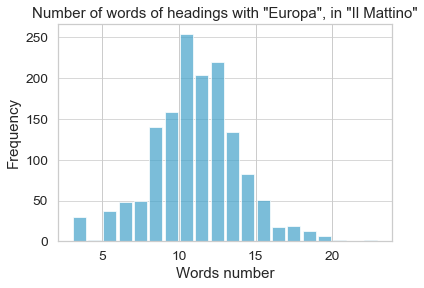

In [292]:
n, bins, patches = plt.hist(x=europe_mat['word_numb'], bins=20, color='#43a2ca',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Words number')
plt.ylabel('Frequency')
plt.title('''Number of words of headings with "Europa", in "Il Mattino"''')
maxfreq = n.max()

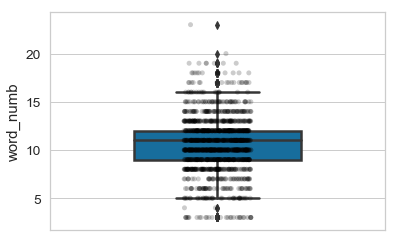

In [267]:
sns.boxplot(y = 'word_numb', 
                 data = europe_mat, 
                 width=0.5,
                 palette="colorblind")
sns.stripplot(y = 'word_numb', 
                   data = europe_mat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

In [226]:
vectorizer_eu_mat = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 0.99,
                             min_df    = 0.01)

In [227]:
vectorizer_eu_mat.fit(elections_mat['Titles'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [228]:
len(vectorizer_eu_mat.get_feature_names())

103

In [229]:
vectorizer_eu_mat.get_feature_names()[0:10]

['2019',
 'accedi',
 'accelera',
 'allan',
 'anni',
 'arriva',
 'autonomia',
 'avellino',
 'avvocati',
 'bacio']

In [230]:
frequency_eu_mat = vectorizer_eu_mat.transform(europe_mat['Titles'])

In [231]:
frequency_eu_mat

<1470x103 sparse matrix of type '<class 'numpy.int64'>'
	with 2574 stored elements in Compressed Sparse Row format>

In [232]:
wordfreq_eu_mat = pd.DataFrame(frequency_eu_mat.toarray(),
                            columns = vectorizer_eu_mat.get_feature_names(),
                            index = europe_mat.index)

In [233]:
wordfreq_eu_mat.head()

,2019,accedi,accelera,allan,anni,arriva,autonomia,avellino,avvocati,bacio,...,ue,unesco,uomo,usa,vale,venezuela,via,voto,youtube,zingaretti
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [234]:
wordfreq_eu_mat.tail()

,2019,accedi,accelera,allan,anni,arriva,autonomia,avellino,avvocati,bacio,...,ue,unesco,uomo,usa,vale,venezuela,via,voto,youtube,zingaretti
44,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
wordfreq_eu_mat.sum().sort_values(ascending=False)[:20]

napoli      467
europa       95
italia       63
salvini      63
mattino      62
dopo         56
due          51
lega         44
allan        42
arriva       42
resta        41
re           38
usa          38
ko           38
stop         37
nuove        36
show         34
uomo         34
tensione     33
pen          33
dtype: int64

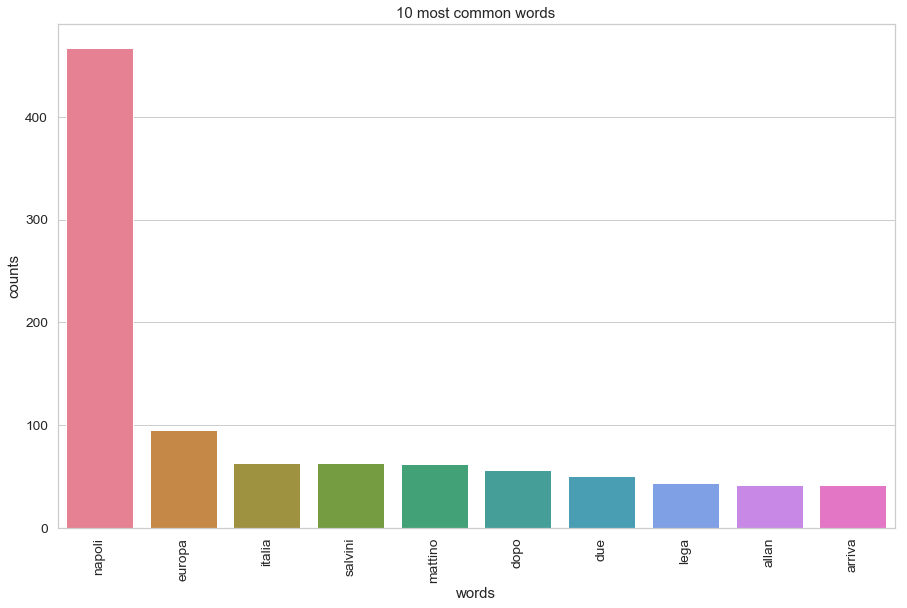

In [236]:
plot_10_most_common_words(frequency_eu_mat, vectorizer_eu_mat)

In [237]:
def best_groups(groups):
    'Looks for the number of groups that gives the best combination of Log Likelihood and Perplexity'
    models = []

    for model in range(1,groups+1):
        lda_model_eu_mat = LatentDirichletAllocation(n_components = model)
        lda_model_eu_mat.fit(frequency_eu_mat)
        loglik = lda_model_eu_mat.score(frequency_eu_mat)
        perpl = lda_model_eu_mat.perplexity(frequency_eu_mat)
        seq = model
        models_dict = {'Log Likelihood': loglik,
                  'Perplexity': perpl,
                  'Groups': seq}
        models.append(models_dict)
    models_df = pd.DataFrame(models)
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Groups')
    models_df.plot.scatter(y = 'Perplexity', x = 'Groups')
    models_df.plot.scatter(y = 'Log Likelihood', x = 'Perplexity')
    return models_df

,Groups,Log Likelihood,Perplexity
0,1,-10422.859171,56.997192
1,2,-10163.812230,51.548253
2,3,-10048.282136,49.289175
3,4,-9845.799970,45.566014
4,5,-9824.521528,45.191466
5,6,-9802.797372,44.812249
6,7,-10090.894264,50.110653
7,8,-9540.148277,40.471603
8,9,-9451.515337,39.103816
9,10,-9434.409371,38.845207


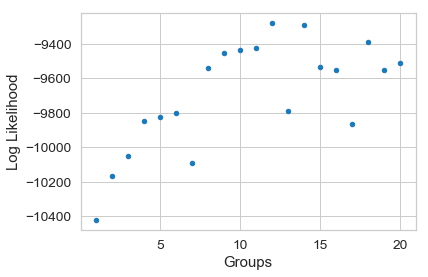

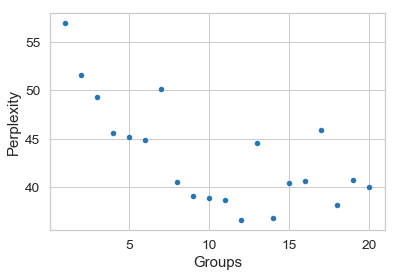

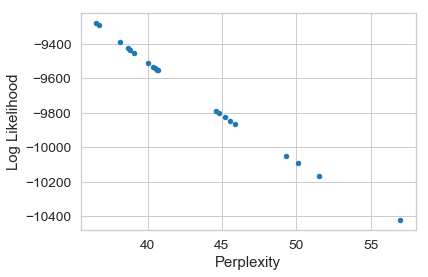

In [238]:
best_groups(20)

In [239]:
lda_model_eu_mat = LatentDirichletAllocation(n_components = 12)

In [240]:
lda_model_eu_mat.fit(frequency_el_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=12, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [241]:
print("Log Likelihood: ", lda_model_eu_mat.score(frequency_eu_mat))

print("Perplexity: ", lda_model_eu_mat.perplexity(frequency_eu_mat))

Log Likelihood:  -10605.350339749157
Perplexity:  61.17813725450589


In [242]:
print(lda_model_eu_mat.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 12, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [243]:
pyLDAvis.enable_notebook()
panel_eu_mat = pyLDAvis.sklearn.prepare(lda_model_eu_mat, frequency_eu_mat, vectorizer_eu_mat, mds='tsne')
panel_eu_mat

/Users/federico/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9     -129.569138  -28.704018       1        1  18.785938
10     123.389519  -86.954330       2        1  11.816078
8       33.623379   45.473804       3        1  11.478023
2      -24.675892  126.252693       4        1  11.230744
11      25.388128 -133.596207       5        1   8.347647
3      130.280319   21.360537       6        1   7.881344
4     -122.677040   79.611496       7        1   6.926625
1      -48.793037   29.597637       8        1   6.756621
0      -82.925255 -126.702698       9        1   5.962386
6       49.504459  -36.941635      10        1   4.067699
5      -32.912079  -52.817741      11        1   3.490244
7       83.636986  119.358643      12        1   3.256649, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
32    Default   58.000000      europee   58.000000  30.0000  30.0000
40    Default   76.000000         lega   76.000000  29.0000  29.0000
50    Default  110.000000       napoli  110.000000  28.0000  28.0000
26    Default   73.000000         dopo   73.000000  27.0000  27.0000
73    Default   47.000000      salvini   47.000000  26.0000  26.0000
46    Default   43.000000      mattino   43.000000  25.0000  25.0000
1     Default   39.000000       accedi   39.000000  24.0000  24.0000
100   Default   47.000000         voto   47.000000  23.0000  23.0000
54    Default   38.000000        nuovo   38.000000  22.0000  22.0000
28    Default   32.000000     elezioni   32.000000  21.0000  21.0000
96    Default   41.000000          usa   41.000000  20.0000  20.0000
27    Default   41.000000          due   41.000000  19.0000  19.0000
38    Default   39.000000       italia   39.000000  18.0000  18.0000
31    Default   31.000000       europa   31.000000  17.0000  17.0000
83    Default   31.000000         stop   31.000000  16.0000  16.0000
5     Default   35.000000       arriva   35.000000  15.0000  15.0000
8     Default   22.000000     avvocati   22.000000  14.0000  14.0000
80    Default   26.000000         show   26.000000  13.0000  13.0000
89    Default   33.000000     tensioni   33.000000  12.0000  12.0000
25    Default   33.000000           de   33.000000  11.0000  11.0000
64    Default   21.000000   presidente   21.000000  10.0000  10.0000
62    Default   32.000000   pomigliano   32.000000   9.0000   9.0000
58    Default   32.000000          pen   32.000000   8.0000   8.0000
44    Default   26.000000         maio   26.000000   7.0000   7.0000
36    Default   24.000000      governo   24.000000   6.0000   6.0000
63    Default   25.000000       pompei   25.000000   5.0000   5.0000
71    Default   42.000000       riapre   42.000000   4.0000   4.0000
67    Default   42.000000       racket   42.000000   3.0000   3.0000
70    Default   31.000000        resta   31.000000   2.0000   2.0000
101   Default   24.000000      youtube   24.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
69    Topic12    0.025164      reddito   12.505738  -2.7841  -8.1126
72    Topic12    0.025164          rui   12.547333  -2.7874  -8.1126
97    Topic12    0.025164         vale   12.547333  -2.7874  -8.1126
3     Topic12    0.025164        allan   12.547333  -2.7874  -8.1126
66    Topic12    0.025164         quel   12.941772  -2.8183  -8.1126
9     Topic12    0.025164        bacio   12.941772  -2.8183  -8.1126
48    Topic12    0.025164     messaggi   12.941772  -2.8183  -8.1126
23    Topic12    0.025164         così   13.013328  -2.8238  -8.1126
10    Topic12    0.025164   berlusconi   13.123952  -2.8323  -8.1126
14    Topic12    0.025164    candidato   13.199891  -2.8381  -8.1126
65    Topic12    0.025164  procuratore   13.336211  -2.8484  -8.1126
47    Topic12    0.025164          may   13.413466  -2.8541  -8.1126
55    Topic12    0.025164          ora  

In [244]:
topic_words_df(lda_model_eu_mat, vectorizer_eu_mat).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
rank,,,,,,,,,,,,
1,governo,europee,lega,mattino,salvini,elezioni,avvocati,consiglio,voto,napoli,usa,stop
2,pd,show,arriva,accedi,maio,candidati,presidente,autonomia,de,dopo,due,treni
3,napoli,pompei,tensioni,nuovo,m5s,comunali,ora,subito,resta,riapre,italia,esonda
4,procuratore,gilmour,pomigliano,europa,lega,2019,sfida,salvini,uomo,racket,tensione,emilia
5,quel,youtube,pen,campania,conte,liste,ordine,settimana,nero,unesco,iran,savio
6,bacio,reddito,scintille,sì,ue,san,elezioni,ministri,poggioreale,chiusura,ko,ex
7,messaggi,berlusconi,nuove,brexit,manovra,avellino,napoli,accelera,cella,cantiere,petroliere,caso
8,rui,candidato,sindacati,san,tav,de,ex,anni,re,sindaco,brexit,politica
9,allan,sud,sud,via,trump,campania,candidato,scontro,noemi,avellino,sud,scontro


In [245]:
topics_eu_mat = lda_model_eu_mat.transform(frequency_eu_mat)

In [246]:
pd.DataFrame(topics_eu_mat).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.027778,0.027778,0.027778,0.694444,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778
1,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
2,0.020833,0.270833,0.020833,0.020833,0.020833,0.270833,0.020834,0.020833,0.020833,0.020833,0.270833,0.020833
3,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.885417,0.010417,0.010417,0.010417,0.010417
4,0.898148,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259,0.009259
5,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
6,0.541667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
7,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
8,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
9,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333


In [247]:
europe_mat['Adjectives'] = europe_mat['Titles'].apply(extract_adjectives)

In [248]:
europe_mat['Adjectives']

0                            AL
1                        social
2        europee, social, russi
3                              
4                              
5                     calabrese
6          fenomenale, contenti
7                              
8                         della
9                              
10                             
11                             
12                             
13                        nella
14                             
15                             
16                     contrari
17                             
18                             
19                  lunga, nera
20    potente, sociale, giovani
21                vero, globale
22                       vicina
23                             
24                 della, della
25                             
26                             
27                             
28                             
29                             
                ...            
19      

In [249]:
vectorizer_eu_mat2 = CountVectorizer(lowercase = True,
                             stop_words = stop_words,
                             max_df    = 1.0,
                             min_df    = 0.0)

In [250]:
vectorizer_eu_mat2.fit(europe_mat['Adjectives'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad', 'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altro', 'anche', 'ancora', 'avemmo', 'avendo', 'avere', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', ...tto', 'un', 'una', 'uno', 'vai', 'vi', 'voi', 'vostra', 'vostre', 'vostri', 'vostro', 'è', 'titolo'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [251]:
wf_eu_mat = vectorizer_eu_mat2.transform(europe_mat['Adjectives'])

In [252]:
df_eu_mat = pd.DataFrame(wf_eu_mat.todense(),
                        columns = vectorizer_eu_mat2.get_feature_names())

In [253]:
df_eu_mat.sum().sort_values(ascending=False)

nuove         36
nero          32
nuovo         18
primo         16
grande        15
prima         13
ex            12
nuova         12
quarti        11
europee       10
arsenal       10
possibile      7
importante     7
nuovi          6
secondo        6
pronto         6
nera           6
pronti         6
italiano       6
anti           5
social         5
felice         5
finale         5
europea        5
migranti       5
italiana       4
azzurri        4
azzurro        4
pronta         4
top            4
              ..
post           1
postale        1
potente        1
pazza          1
parli          1
naturale       1
onde           1
necessario     1
negativo       1
neo            1
nere           1
nevica         1
normale        1
normali        1
nota           1
noto           1
olimpica       1
open           1
palazzetto     1
operativa      1
operatoria     1
orgogliosi     1
originali      1
oscurata       1
ottavo         1
ottimo         1
ovale          1
ovarico       